Images
====

An ``Images`` object is a collection of either 2D images or 3D volumes. Under the hood, it wraps an n-dimensional array, and supports either distributed operations via Spark or local operations via `numpy`, with an identical API. It supports several simple manipulations of image content, exporting image data, and conversion to other formats. 

This example can be run locally and does not require Spark.

## Setup imports

In [1]:
%matplotlib inline

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')
from showit import image, tile

In [3]:
import thunder as td

## Loading images

`images` data can be loaded using the `td.images.from*` methods, which support loading from a few different formats. Here we'll load example data.

In [4]:
data = td.images.fromexample('fish')

We can inspect the object to see basic properties like `shape`, `dtype`, and whether it's in `'local'` or `'spark'` mode.

In [5]:
data

Images
mode: local
dtype: uint8
shape: (20, 2, 76, 87)

These are 20 3d volumes, each one with shape `(2, 76, 87)`. Let's look at the first volume

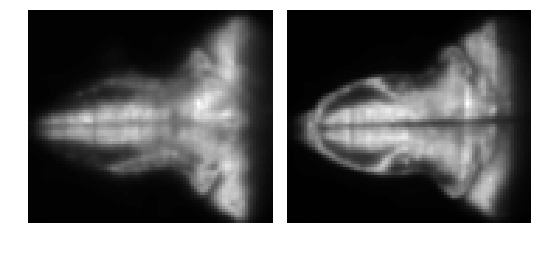

In [6]:
tile(data[0]);

Note that, although `data` is not itself an array, we can index into it using bracket notation, and pass it as input to plotting methods that expect arrays, because it will be automatically converted.

For an example of 2D data, we can load another one of the examples

In [7]:
data = td.images.fromexample('mouse')

Look at the first image

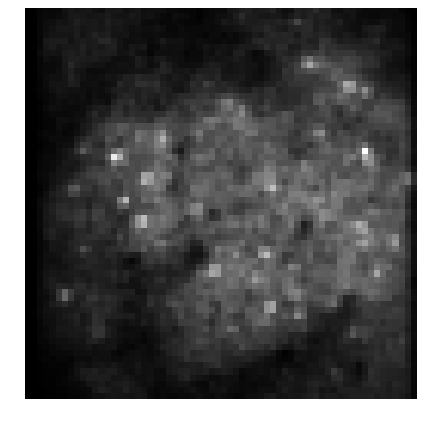

In [8]:
image(data[0]);

## Image manipulations

An ``Images`` object has a variety of methods for manipulation, all of which are automatically parallelized across images if running on a cluster.

One common manipulation on volumetric data is computing a maximum projection across the z dimension.

In [9]:
data = td.images.fromexample('fish')

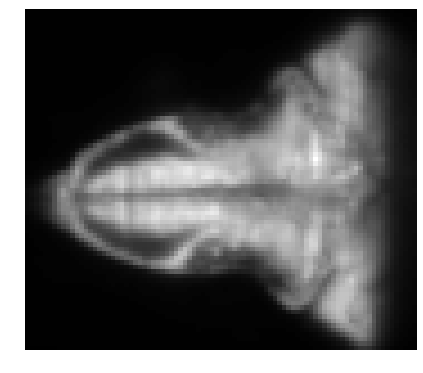

In [10]:
projections = data.max_projection(axis=0)
image(projections[0]);

We can also subselect a set of planes, specifying the top and bottom of the desired range:

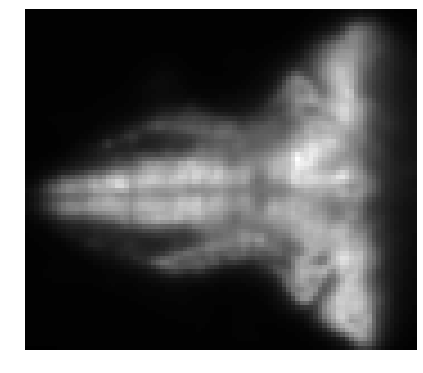

In [11]:
subset = data[0, 0, :, :]
image(subset);

And we can subsample in space:

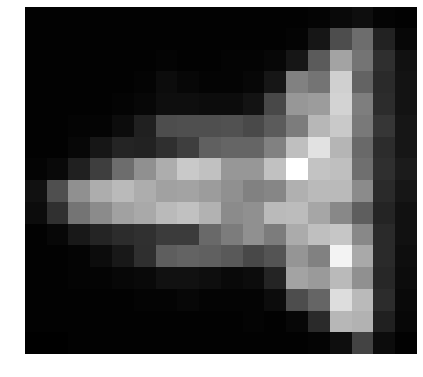

In [12]:
subsampled = data.subsample([1,5,5])[0, 0, :, :]
image(subsampled);

Finally, we can perform operations that aggregate across images. For example, computing the standard deviation:

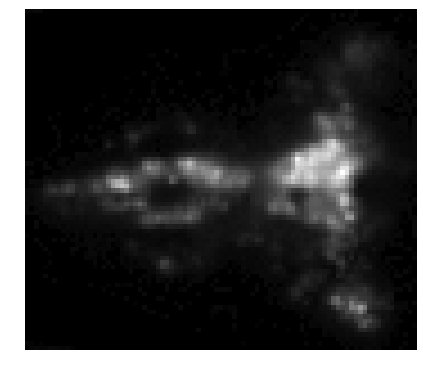

In [13]:
statistic = data.std()[0, 0, :, :]
image(statistic);

The result of image operations can be saved by exporting each image to a `png` or `tif` file.

```
data.max_projection(axis=0).topng('directory')
data.max_projection(axis=0).totif('directory')
```

## Conversions

We commonly encounter images or volumes that vary over time, e.g. from a movie. It can be useful to convert these data into a `Series` object: another wrapper for n-dimensional arrays designed to work with collections of one-dimensional indexed records, often time series.

Here we load our `image` data and convert to `series`

In [14]:
data = td.images.fromexample('fish')
ts = data.toseries()

Let's check properties of the `Series` to make sure the conversion makes sense. We have twenty images, so there should be twenty time points.

In [15]:
ts.index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

The shape should be the original pixel dimensions `(2, 76, 87)` and the time dimension `(20)`

In [16]:
ts.shape

(2, 76, 87, 20)

This conversion from `images` to `series` is essentially a transpose, but in the distributed setting it uses an efficient blocked representation.

If we want to collapse the pixel dimensions, we can use `flatten`

In [17]:
ts.flatten().shape

(13224, 20)

We can also quickly look at some example time series, after filtering on standard deviation and normalizing.

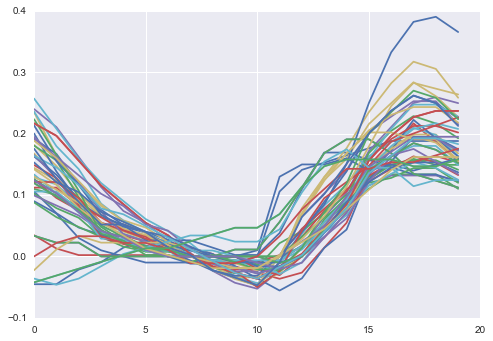

In [18]:
samples = ts.flatten().filter(lambda x: x.std() > 6).normalize().sample(n=50).toarray()
plt.plot(samples.T);

For a large data set that will be analyzed repeatedly as `series`, it might be faster and more convienient to save `images` data to a collection of flat binary files on a distributed file system, which can in turn be read back in directly as `series` data. This can be performed as follows:

```
data = td.images.fromexample('fish')
data.toseries().tobinary('directory', overwrite=True)
ts = td.series.frombinary('directory')
```

There are more methods on `images` data, and algorithm packages that take `images` data as input. See the other tutorials and documentation for more!